In [1]:
import pandas as pd
import numpy as np
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier

import warnings

from DataPreparation import DataPreparation

In [22]:
pics = './images'
data_path = './data'

In [5]:
df = pd.read_csv(f'{data_path}/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine,label
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,9.103951,-0.051090,3.459112,1.375036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,9.103026,-0.051090,3.450909,1.367373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,9.103025,-0.051090,3.448581,1.360843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,5.825210,-0.051059,3.346646,1.323034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,9.101988,0.552888,3.020157,1.976391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
X = df.drop(columns=['label'])
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
y_test.value_counts()

0    915
1    915
Name: label, dtype: int64

In [8]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = data_preparation.clean_dataset()
feats = data_preparation.feature_names
X_train.shape

Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'SPS',
       'MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW',
       'BCUT2D_CHGHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA2', 'PEOE_VSA3',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA8', 'SMR_VSA2', 'SMR_VSA3',
       'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
       'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5',
       'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA5',
       'VSA_EState1', 'VSA_EState6', 'VSA_EState7', 'NumAliphaticCarbocycles',
       'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumHeteroatoms',
       'NumRotatableBonds', 

(4270, 83)

## Feature selection

### Feature selection using Random Forest Classifier

In [9]:
Rtree_clf = RandomForestClassifier(random_state=42)
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain = X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]
warnings.filterwarnings('ignore')

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices = indices[:200]

In [10]:
top_20_rf = feats[indices[:20]]
top_20_rf

Index(['PEOE_VSA6', 'HallKierAlpha', 'BCUT2D_MWHI', 'PEOE_VSA1', 'Chi0v',
       'AvgIpc', 'SlogP_VSA3', 'fr_HOCCN', 'Chi3v', 'qed', 'MinAbsEStateIndex',
       'fr_COO', 'fr_benzodiazepine', 'BCUT2D_MWLOW', 'MinPartialCharge',
       'EState_VSA1', 'NumAliphaticCarbocycles', 'PEOE_VSA8',
       'MaxPartialCharge', 'fr_Al_OH_noTert'],
      dtype='object')

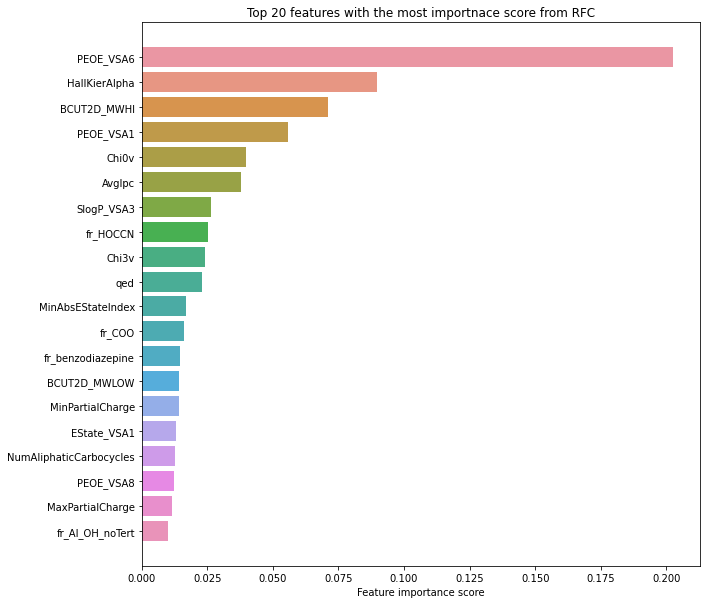

In [11]:
feature_scores = pd.Series(Rtree_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=importances[indices][:20], y=top_20_rf)
ax.set_title("Top 20 features with the most importnace score from RFC")
ax.set_xlabel("Feature importance score")
plt.autoscale()
# plt.show()
plt.savefig(f'{pics}/rf_feat_score.png')

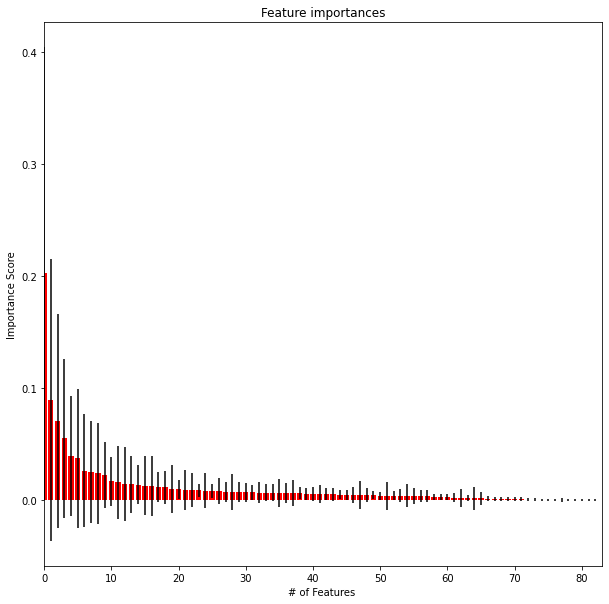

In [12]:
plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(len(importances[indices])), importances[indices], color="r", yerr=std[indices], align="center")
plt.xlim([0, len(importances[indices])])
plt.show()
# plt.savefig(f'{pics}/rf_feat_import.png')

### 1.13.3. Recursive Feature Elmination

In [13]:
clf = RandomForestClassifier(n_estimators=50, max_depth=20)
min_features_to_select = 10
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

# size = 6050
size = X_train.shape[0]
rfecv.fit(X_train[:size], y_train[:size])
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 65


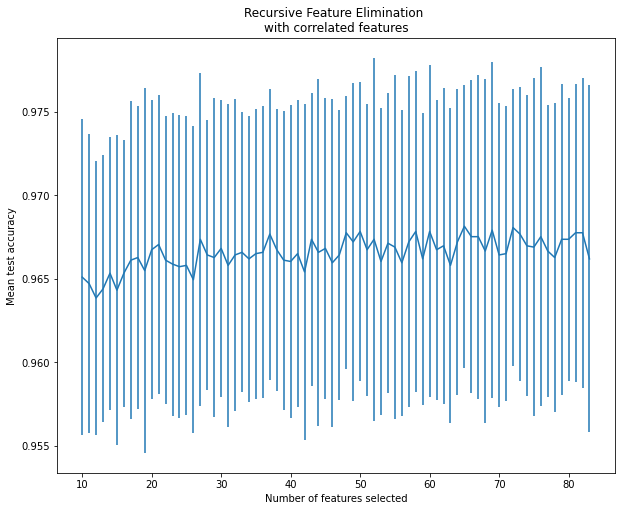

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()
plt.savefig(f'{pics}/rfe_with_corr_feat.png')

### Applying RFE with optimal number of features found in RFECV

In [15]:
clf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rfe = RFE(estimator=clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train)

In [16]:
rfe_train = pd.DataFrame(X_train).loc[:, rfe.get_support()]
rfe_test = pd.DataFrame(X_test).loc[:, rfe.get_support()]

print("Train Accuracy:",cross_val_score(clf,rfe_train,y_train, cv=5).mean())

clf = clf.fit(rfe_train, y_train)
y_pred = clf.predict(rfe_test)
print()

print(classification_report(y_test, y_pred))

Train Accuracy: 0.9651053864168617

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       915
           1       0.96      0.99      0.97       915

    accuracy                           0.97      1830
   macro avg       0.97      0.97      0.97      1830
weighted avg       0.97      0.97      0.97      1830



In [17]:
rfe_feats = feats[rfe.get_support()]
print('Numbber of features after RFE:', rfe_feats.shape[0])
rfe_feats

Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'SPS',
       'MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW',
       'BCUT2D_CHGHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA2', 'PEOE_VSA3',
       'PEOE_VSA6', 'PEOE_VSA8', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
       'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5',
       'SlogP_VSA6', 'SlogP_VSA8', 'EState_VSA1', 'EState_VSA5', 'VSA_EState1',
       'NumAliphaticCarbocycles', 'RingCount', 'fr_Al_OH_noTert', 'fr_COO',
       'fr_HOCCN', 'fr_benzene', 'fr_benzodiazepine', 'fr_diazo'],
      dtype='object')

In [30]:
importance = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
forest_importances = pd.Series(importance, index=rfe_feats)
top_20_rfe = forest_importances.sort_values(ascending=False)[:20]
top_20_rfe.index

Index(['PEOE_VSA6', 'HallKierAlpha', 'BCUT2D_MWHI', 'PEOE_VSA1', 'AvgIpc',
       'Chi0v', 'fr_HOCCN', 'Chi3v', 'SlogP_VSA3', 'qed',
       'NumAliphaticCarbocycles', 'MinAbsEStateIndex', 'fr_COO',
       'MinPartialCharge', 'BCUT2D_MWLOW', 'SlogP_VSA2', 'PEOE_VSA8',
       'MaxPartialCharge', 'SlogP_VSA12', 'SMR_VSA3'],
      dtype='object')

In [44]:
idx = top_20_rfe.index.append(pd.Index(['label']))
select_data = df[idx]
select_data.to_csv(f'{data_path}/feat_sel_data.csv', index=False)

In [ ]:
# select_data = pd.read_csv(f'{data_path}/feat_sel_data.csv')
# select_data

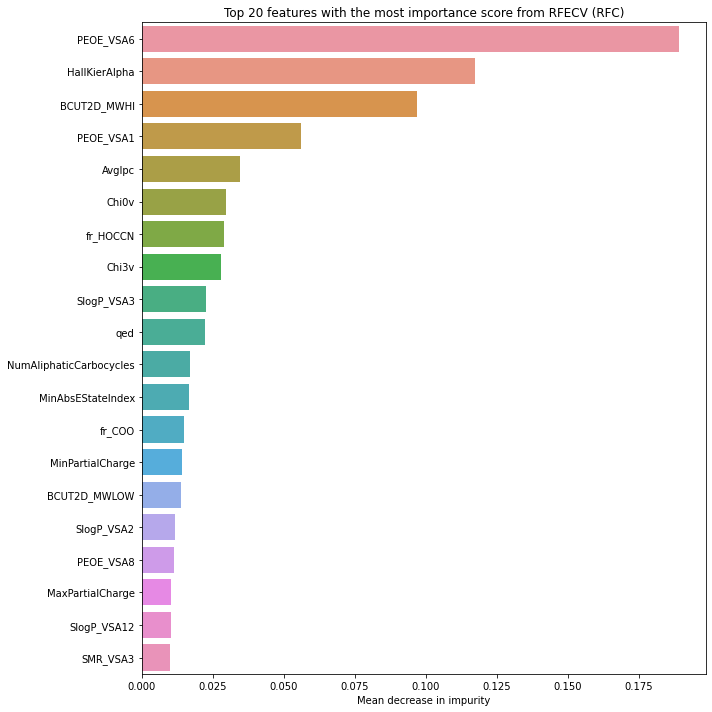

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=top_20_rfe, y=top_20_rfe.index)
ax.set_title("Top 20 features with the most importance score from RFECV (RFC)")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()
# plt.show()
plt.savefig(f'{pics}/rfe_feat_score.png')

### Plot the two horizontal subplots RFC and RFECV

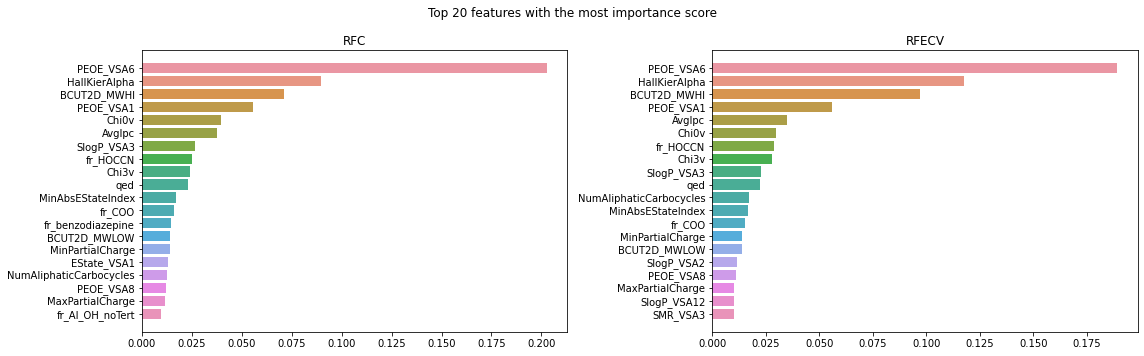

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
fig.suptitle("Top 20 features with the most importance score")
ax1 = sns.barplot(x=importances[indices][:20], y=top_20_rf, ax=ax1)
ax1.plot()
ax1.set_title("RFC")
ax2 = sns.barplot(x=top_20_rfe, y=top_20_rfe.index, ax=ax2)
ax2.set_title("RFECV")
ax2.plot()
plt.autoscale()
fig.tight_layout()
# plt.show()
plt.savefig(f'{pics}/feat_score_comb.png')